# Report for the Collaboration and Competition Project

## Setting up the environment

### Unity environment configuration

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
env = UnityEnvironment(file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### Examine the action and state spaces

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Take random actions in the environment

In [5]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.0
Score (max over agents) from episode 5: 0.0


### Action and state space and MADDPG configuration

The objective of Unity's [Tennis environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) is to train two agents to play tennis with each other in a cooperative way. The agents are rewarded for keeping the ball in play as long as possible. The task is considered solved when the average reward of the winning agent each episode hits 0.5 over 100 consecutive episodes.

**Action space:** For each of the two tennis rackets, two continuous actions are available, corresponding to movement toward or away from the net, and jumping.

**State space:** Each agent receives its own observation, consisting of 8 dimensions (position and velocity of the ball and the respective tennis racket). 

**Reward function:** The agents receives a reward after taking an action. A +0.1 reward is given if the agent hits the ball over the net and a -0.01 penalty if they miss the ball or hit it out of bounds. The algorithm provides to each agent the velocity and position of both agents and the ball, but only tells each agent their own reward, not the reward of the other agent. v

**MADDPG structure:** The adopted learning algorithm is a multi-agent variant of the DDPG algorithm (MADDPG), a model-free, off-policy, policy gradient-based algorithm that uses two separate deep neural networks (an actor and a critic) to both explore the stocastic environment and, separately, learn the best policy to achieve maximum reward. DDPG has been shown to be quite effective at continuous control tasks and here the multi-agent version is applied to this collaborative task.

MADDPG is a multi-agent Actor-Critic model: 
* Each Actor is a policy-based algorithm with high variance, taking relatively long to converge.
* Each Critic is a value-based algorithm with high bias instead

In this approach, each agent's Actor and Critic work together to reach better convergence and performance.

**Actor models**

Two individual neural networks with 3 fully connected layers:
* Fully connected layer 1: with input = 48 (twice the state space) and output = 256
* Fully connected layer 2: with input = 256 and output = 128
* Fully connected layer 3: with input = 128 and output = 2 (action space)

Tanh is used in the final layer that maps states to actions. Batch normalization is used for mini batch training.

**Critic models**

Two individual neural networks with 3 fully connected layers:
* Fully connected layer 1: with input = 48 (twice the state space) and output = 256
* Fully connected layer 2: with input = 260 (states and actions) and output = 128
* Fully connected layer 3: with input = 128 and output = 1 (maps states and actions to Q-values)

**Parameters used in the MADDPG algorithm:**
* Replay buffer size: BUFFER_SIZE = int(1e6)
* Minibatch size: BATCH_SIZE = 128
* Discount factor: GAMMA = 0.99
* Soft update of target parameters: TAU = 6e-2
* Learning rate of the actor: LR_ACTOR = 1e-3
* Learning rate of the critic: LR_CRITIC = 1e-3
* L2 weight decay: WEIGHT_DECAY = 0
* Time steps between network updates: UPDATE_EVERY = 1
* Number of times training: N_UPDATES = 1
* Noise level start: eps_start = 6 
* Noise level end: eps_end = 0   
* Number of episodes to decay over from start to end: eps_decay = 250  


### Import packages

In [6]:
import random
import copy
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import pytz

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("Europe/Berlin"))
    return pst_now.strftime(format)

### Setup actor-critic networks

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size*2, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size*2, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+(action_size*2), fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fcs1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

## Setup agents

In [8]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            num_agents (int): number of agents
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.num_agents = num_agents
        self.seed = random.seed(random_seed)
        self.eps = eps_start
        self.t_step = 0

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
                
        # Noise process
        self.noise = OUNoise((num_agents, action_size), random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
    
    def step(self, state, action, reward, next_state, done, agent_number):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.t_step += 1
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)
    
        # Learn, if enough samples are available in memory and at interval settings
        if len(self.memory) > BATCH_SIZE:
            if self.t_step % UPDATE_EVERY == 0:
                for _ in range(N_UPDATES):
                    experiences = self.memory.sample()
                    self.learn(experiences, GAMMA, agent_number)

    def act(self, states, add_noise):
        """Returns actions for given state as per current policy."""
        states = torch.from_numpy(states).float().to(device)
        actions = np.zeros((self.num_agents, self.action_size))
        self.actor_local.eval()
        with torch.no_grad():
            for agent_num, state in enumerate(states):
                action = self.actor_local(state).cpu().data.numpy()
                actions[agent_num, :] = action
        self.actor_local.train()
        if add_noise:
            actions += self.eps * self.noise.sample()
        return np.clip(actions, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma, agent_number):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        
        if agent_number == 0:
            actions_next = torch.cat((actions_next, actions[:,2:]), dim=1)
        else:
            actions_next = torch.cat((actions[:,:2], actions_next), dim=1)
            
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        
        if agent_number == 0:
            actions_pred = torch.cat((actions_pred, actions[:,2:]), dim=1)
        else:
            actions_pred = torch.cat((actions[:,:2], actions_pred), dim=1)

        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     

        # Update epsilon noise value
        self.eps = self.eps - (1/eps_decay)
        if self.eps < eps_end:
            self.eps=eps_end
                  
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
            
            
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0.0, theta=0.13, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.size = size
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state
    
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## MADDPG training and results:

In [9]:
BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
LR_ACTOR = 1e-3         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 6e-2              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay
UPDATE_EVERY = 1        # time steps between network updates
N_UPDATES = 1           # number of times training
ADD_NOISE = True

eps_start = 6           # Noise level start
eps_end = 0             # Noise level end
eps_decay = 250         # Number of episodes to decay over from start to end

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

""" Setup two independent agents with shared experience memory """
agent_0 = Agent(state_size, action_size, 1, random_seed=0)
agent_1 = Agent(state_size, action_size, 1, random_seed=0)

In [10]:
print ("***STARTED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

n_episodes = 1000
scores_window = deque(maxlen=100)
scores_all = []
rolling_average = []

for i_episode in range(1, n_episodes+1):
    env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
    states = env_info.vector_observations
    states = np.reshape(states, (1,48))
    agent_0.reset()
    agent_1.reset()
    scores = np.zeros(num_agents)
    while True:
        action_0 = agent_0.act(states, ADD_NOISE)           # agent 1 chooses an action
        action_1 = agent_1.act(states, ADD_NOISE)           # agent 2 chooses an action
        actions = np.concatenate((action_0, action_1), axis=0) 
        actions = np.reshape(actions, (1, 4))
        env_info = env.step(actions)[brain_name]           # send both agents' actions together to the environment
        next_states = env_info.vector_observations         # get next states
        next_states = np.reshape(next_states, (1, 48))     # combine each agent's state into one state space
        rewards = env_info.rewards                         # get reward
        done = env_info.local_done                         # see if episode finished

        agent_0.step(states, actions, rewards[0], next_states, done, 0) # agent 1 learns
        agent_1.step(states, actions, rewards[1], next_states, done, 1) # agent 2 learns
        scores += rewards                                  # update the score for each agent
        states = next_states                               # roll over states to next time step

        if np.any(done):                                  # exit loop if episode finished
            break

    scores_window.append(np.max(scores))
    scores_all.append(np.max(scores))
    rolling_average.append(np.mean(scores_window))
                
    if i_episode % 10 == 0:
        print('Episode {}\tMax Reward: {:.3f}\tAverage Reward: {:.3f}'.format(
            i_episode, np.max(scores), np.mean(scores_window)))

    if np.mean(scores_window)>=0.5:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.3f}'.format(
            i_episode-100, np.mean(scores_window)))
        torch.save(agent_0.actor_local.state_dict(), 'checkpoint_actor_0.pth')
        torch.save(agent_0.critic_local.state_dict(), 'checkpoint_critic_0.pth')
        torch.save(agent_1.actor_local.state_dict(), 'checkpoint_actor_1.pth')
        torch.save(agent_1.critic_local.state_dict(), 'checkpoint_critic_1.pth')
        break

print ("***FINISHED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

***STARTED TRAINING AT 2018-11-19--11:17:43 
Episode 10	Max Reward: 0.090	Average Reward: 0.009
Episode 20	Max Reward: 0.000	Average Reward: 0.010
Episode 30	Max Reward: 0.000	Average Reward: 0.006
Episode 40	Max Reward: 0.000	Average Reward: 0.007
Episode 50	Max Reward: 0.000	Average Reward: 0.006
Episode 60	Max Reward: 0.000	Average Reward: 0.008
Episode 70	Max Reward: 0.000	Average Reward: 0.008
Episode 80	Max Reward: 0.000	Average Reward: 0.009
Episode 90	Max Reward: 0.000	Average Reward: 0.012
Episode 100	Max Reward: 0.000	Average Reward: 0.016
Episode 110	Max Reward: 0.000	Average Reward: 0.017
Episode 120	Max Reward: 0.000	Average Reward: 0.022
Episode 130	Max Reward: 0.000	Average Reward: 0.024
Episode 140	Max Reward: 0.100	Average Reward: 0.029
Episode 150	Max Reward: 0.100	Average Reward: 0.036
Episode 160	Max Reward: 0.000	Average Reward: 0.035
Episode 170	Max Reward: 0.000	Average Reward: 0.043
Episode 180	Max Reward: 0.100	Average Reward: 0.045
Episode 190	Max Reward: 0.00

## Rewards progression

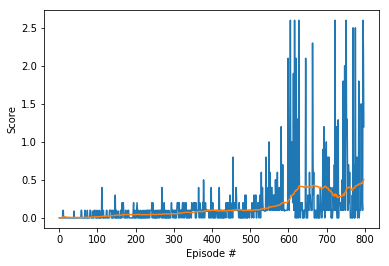

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_all)+1), scores_all)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Load and watch the trained MADDPG algorithm

In [16]:
# Load the saved training parameters
agent_0.actor_local.load_state_dict(torch.load('checkpoint_actor_0.pth', map_location='cpu'))
agent_0.critic_local.load_state_dict(torch.load('checkpoint_critic_0.pth', map_location='cpu'))
agent_1.actor_local.load_state_dict(torch.load('checkpoint_actor_1.pth', map_location='cpu'))
agent_1.critic_local.load_state_dict(torch.load('checkpoint_critic_1.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)[brain_name]        
states = env_info.vector_observations                  
states = np.reshape(states, (1,48))

for i in range(200):
    action_0 = agent_0.act(states, add_noise=False)         
    action_1 = agent_1.act(states, add_noise=False)        
    actions = np.concatenate((action_0, action_1), axis=0) 
    actions = np.reshape(actions, (1, 4))
    env_info = env.step(actions)[brain_name]        
    next_states = env_info.vector_observations        
    next_states = np.reshape(next_states, (1, 48))
    rewards = env_info.rewards                        
    dones = env_info.local_done                 
    states = next_states                              
    if np.any(dones):                              
        break

### Summary and further optimization proposal

The described MADDPG solution could be improved to be more robust, as training sessions yield very different results. As a next step, it would be worth exploring ways to increase reliability of the learning progression for this setup. 

There are several potential approaches to further increase the accuracy of the DDPG agents, such as Trust Region Policy Optimization (TRPO) and Truncated Natural Policy Gradient (TNPG), as discussed in the following paper on ["Benchmarking Deep Reinforcement Learning for Continuous Control"](https://arxiv.org/abs/1604.06778). Also, ["Distributed Distributional Deterministic Policy Gradients (D4PG)"](https://arxiv.org/abs/1804.08617) could be an interesting option.

In [17]:
env.close()